# Initialize notebook

In [70]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import seaborn as sn

import sklearn as skl
from sklearn.linear_model import LinearRegression
import sklearn.pipeline as skl_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from scipy.optimize import curve_fit

In [2]:
# Constants
KITTI_DATASET = '/media/javier/HDD_linux/KITTI_dataset/'

# Create dataframe

In [11]:
# Calculate distance between two 3D points
def distance(a,b):
    return math.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2+(a[2]-b[2])**2)

# Get KITTIs TXT file and save it as a CSV file
def kitti_2_csv(label_path, save_path='./'):

    files = sorted(os.listdir(label_path))
    col = ['frame','id','type','truncated','occluded','alpha','left','top','right','bottom','height','width','length','x','y','z','ry']
    frame = 0
    lines = []

    for f in files:

        id = 0
        labels_f = open(label_path+f,'r')

        # Add every line of the TXT file to the pandas dataframe
        for line in labels_f:
            line = line.split()
            line = [str(line[0])]+[float(i) for i in line[1:]]
            line.insert(0,frame)
            line.insert(1,id)
            if(line[2] == 'Car' or line[2] == 'Cyclist' or line[2] == 'Pedestrian'):
                lines.append(line)
                id += 1

        frame += 1
        labels_f.close()

    df = pd.DataFrame(lines, columns=col)
    
    # Add extra columns
    df['distance'] = (df.apply(lambda row: distance([0,0,0],[row['x'],row['y'],row['z']]), axis=1))
    df['heigth_image'] = (df.apply(lambda row: row['bottom']-row['top'], axis=1))
    df['width_image'] = (df.apply(lambda row: row['right']-row['left'], axis=1))
    df['theta_ray'] = (df.apply(lambda row: round(((row['ry']-row['alpha'])+math.pi)%(2*math.pi)-math.pi, 2), axis=1))
    
    df.to_csv(save_path+'kitti_gt.csv',columns=col+['distance','heigth_image','width_image','theta_ray'],index=False)
    
# Call the fuction
kitti_2_csv(KITTI_DATASET+'training/label_2/', KITTI_DATASET+'training/')

In [12]:
# Open CSV file and transform to pandas dataframe
df = pd.read_csv(KITTI_DATASET+'training/kitti_gt.csv')
df

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,...,width,length,x,y,z,ry,distance,heigth_image,width_image,theta_ray
0,0,0,Pedestrian,0.0,0.0,-0.20,712.40,143.00,810.73,307.92,...,0.48,1.20,1.84,1.47,8.41,0.01,8.733533,164.92,98.33,0.21
1,1,0,Car,0.0,0.0,1.85,387.63,181.54,423.81,203.12,...,1.87,3.69,-16.53,2.39,58.49,1.57,60.827897,21.58,36.18,-0.28
2,1,1,Cyclist,0.0,3.0,-1.65,676.60,163.95,688.98,193.93,...,0.60,2.02,4.59,1.32,45.84,-1.55,46.088134,29.98,12.38,0.10
3,2,0,Car,0.0,0.0,-1.67,657.39,190.13,700.07,223.39,...,1.58,4.36,3.18,2.27,34.38,-1.58,34.601296,33.26,42.68,0.09
4,3,0,Car,0.0,0.0,1.55,614.24,181.78,727.31,284.77,...,1.73,4.15,1.00,1.75,13.22,1.62,13.372767,102.99,113.07,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34851,7480,9,Car,0.0,2.0,-0.33,749.78,170.88,917.51,243.48,...,1.69,3.82,5.72,1.75,18.85,-0.04,19.776334,72.60,167.73,0.29
34852,7480,10,Car,0.0,1.0,-2.90,344.07,180.05,479.10,224.15,...,1.59,4.44,-7.12,1.78,26.03,3.12,27.044846,44.10,135.03,-0.26
34853,7480,11,Car,0.0,2.0,-2.91,382.70,179.71,495.48,219.10,...,1.63,4.10,-6.79,1.78,28.78,-3.14,29.623654,39.39,112.78,-0.23
34854,7480,12,Car,0.0,0.0,-1.69,631.71,179.85,678.40,214.37,...,1.56,4.08,1.90,1.74,31.98,-1.63,32.083610,34.52,46.69,0.06


# Analyze dataset

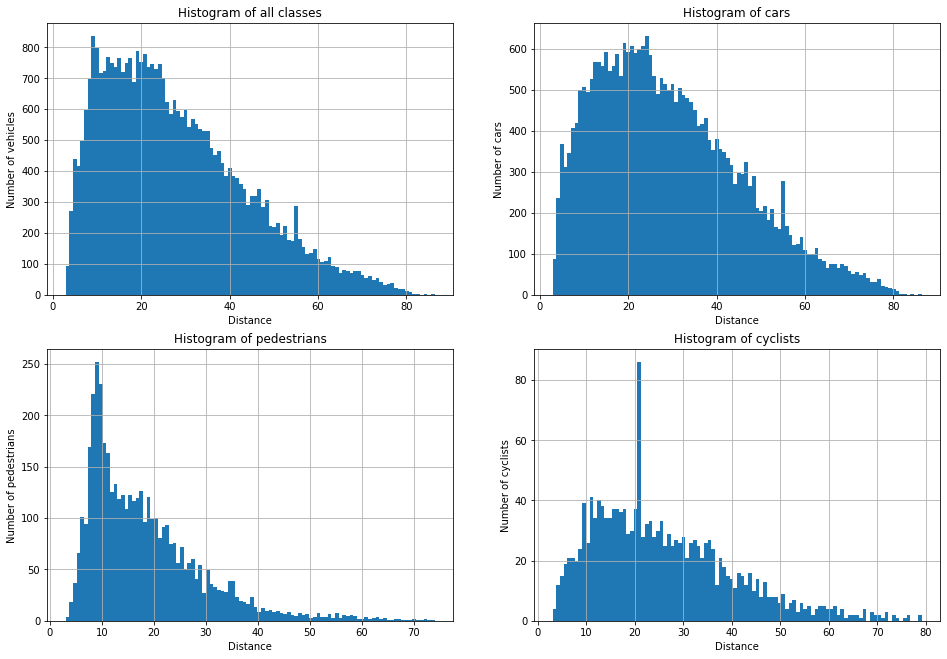

*All classes*
count    34856.000000
mean        27.809565
std         16.090348
min          2.881562
25%         15.007452
50%         24.754214
75%         37.745696
max         86.434801
Name: distance, dtype: float64

*Car*
count    28742.000000
mean        29.378774
std         16.319714
min          2.881562
25%         16.472982
50%         26.782781
75%         39.882227
max         86.434801
Name: distance, dtype: float64

*Pedestrian*
count    4487.000000
mean       18.442209
std        11.196722
min         3.032507
25%         9.866880
50%        15.713081
75%        23.513701
max        74.029991
Name: distance, dtype: float64

*Cyclist*
count    1627.000000
mean       25.922131
std        14.387199
min         3.069039
25%        14.985584
50%        22.905663
75%        34.379485
max        79.153998
Name: distance, dtype: float64


In [13]:
plt.figure(figsize=(16, 11)) 

plt.subplot(2, 2, 1)
df['distance'].hist(bins=100)
plt.title('Histogram of all classes')
plt.xlabel('Distance')
plt.ylabel('Number of vehicles')


plt.subplot(2, 2, 2)
df[df['type'] == 'Car']['distance'].hist(bins=100)
plt.title('Histogram of cars')
plt.xlabel('Distance')
plt.ylabel('Number of cars')


plt.subplot(2, 2, 3)
df[df['type'] == 'Pedestrian']['distance'].hist(bins=100)
plt.title('Histogram of pedestrians')
plt.xlabel('Distance')
plt.ylabel('Number of pedestrians')


plt.subplot(2, 2, 4)
df[df['type'] == 'Cyclist']['distance'].hist(bins=100)
plt.title('Histogram of cyclists')
plt.xlabel('Distance')
plt.ylabel('Number of cyclists')
plt.show()

print('*All classes*')
print(df['distance'].describe())
print()
print('*Car*')
print(df[df['type'] == 'Car']['distance'].describe())
print()
print('*Pedestrian*')
print(df[df['type'] == 'Pedestrian']['distance'].describe())
print()
print('*Cyclist*')
print(df[df['type'] == 'Cyclist']['distance'].describe())

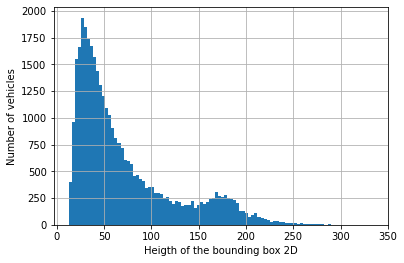

count    34856.000000
mean        71.464068
std         52.739822
min         12.670000
25%         32.670000
50%         51.730000
75%         93.280000
max        334.530000
Name: heigth_image, dtype: float64


In [14]:
df['heigth_image'].hist(bins=100)
plt.xlabel('Heigth of the bounding box 2D')
plt.ylabel('Number of vehicles')
plt.show()

print(df['heigth_image'].describe())

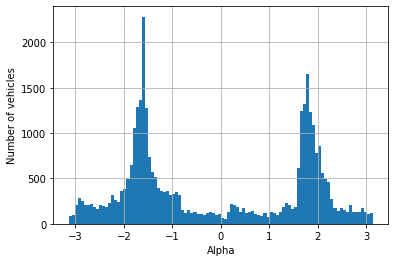

count    34856.000000
mean        -0.088102
std          1.796026
min         -3.140000
25%         -1.660000
50%         -0.775000
75%          1.780000
max          3.140000
Name: alpha, dtype: float64


In [15]:
df['alpha'].hist(bins=100)
plt.xlabel('Alpha')
plt.ylabel('Number of vehicles')
plt.show()

print(df['alpha'].describe())

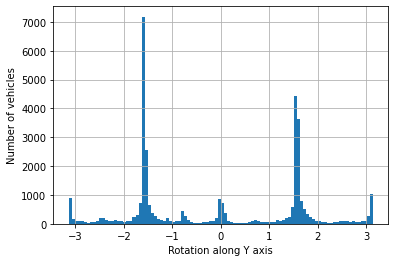

count    34856.000000
mean        -0.078953
std          1.727295
min         -3.140000
25%         -1.580000
50%         -0.180000
75%          1.570000
max          3.140000
Name: ry, dtype: float64


In [16]:
df['ry'].hist(bins=100)
plt.xlabel('Rotation along Y axis')
plt.ylabel('Number of vehicles')
plt.show()

print(df['ry'].describe())

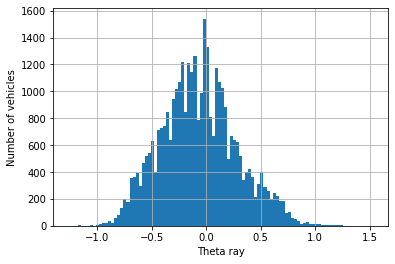

count    34856.000000
mean        -0.064361
std          0.349308
min         -1.260000
25%         -0.300000
50%         -0.080000
75%          0.150000
max          1.530000
Name: theta_ray, dtype: float64


In [17]:
df['theta_ray'].hist(bins=100)
plt.xlabel('Theta ray')
plt.ylabel('Number of vehicles')
plt.show()

print(df['theta_ray'].describe())

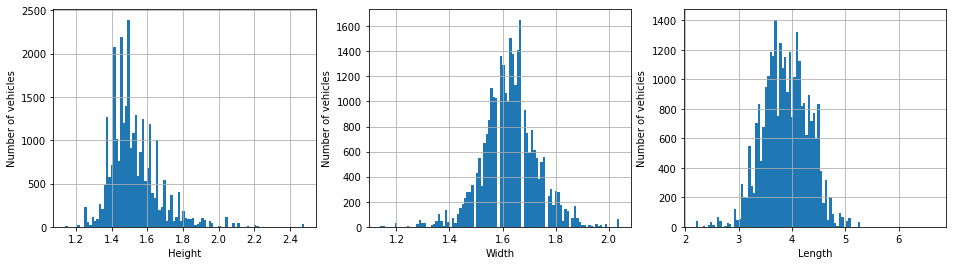

In [60]:
plt.figure(figsize=(16, 4))

df_car = df[df['type'] == 'Car']

plt.subplot(1, 3, 1)
df_car['height'].hist(bins=100)
plt.xlabel('Height')
plt.ylabel('Number of vehicles')

plt.subplot(1, 3, 2)
df_car['width'].hist(bins=100)
plt.xlabel('Width')
plt.ylabel('Number of vehicles')

plt.subplot(1, 3, 3)
df_car['length'].hist(bins=100)
plt.xlabel('Length')
plt.ylabel('Number of vehicles')

plt.show()

print('*Car*')
print(df_car['height'].describe())
print()
print('*Pedestrian*')
print(df_car['width'].describe())
print()
print('*Cyclist*')
print(df_car['length'].describe())

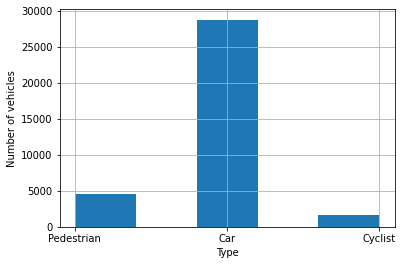

In [26]:
df['type'].hist(bins=5)
plt.xlabel('Type')
plt.ylabel('Number of vehicles')
plt.show()

# Statistical analysis

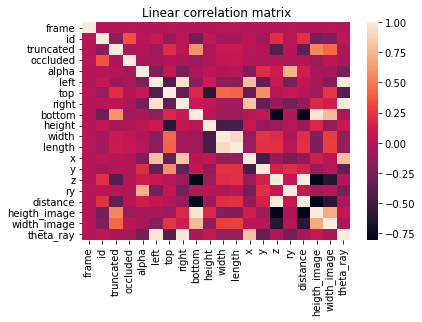

In [18]:
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=False)
plt.title('Linear correlation matrix')
plt.show()

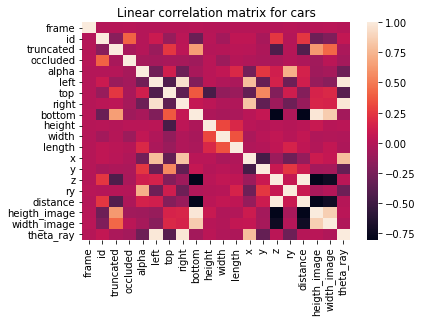

In [27]:
corrMatrix = df[df['type'] == 'Car'].corr()
sn.heatmap(corrMatrix, annot=False)
plt.title('Linear correlation matrix for cars')
plt.show()

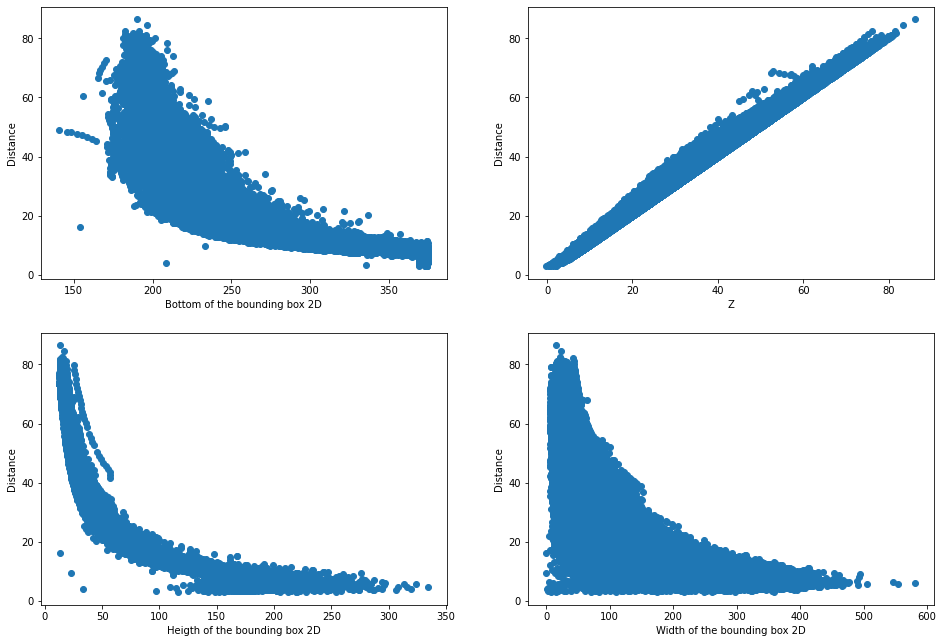

In [85]:
plt.figure(figsize=(16, 11))

Y = df['distance'].values.reshape(-1, 1)

plt.subplot(2, 2, 1)
X = df['bottom'].values.reshape(-1, 1)
plt.scatter(X, Y)
plt.ylabel('Distance')
plt.xlabel('Bottom of the bounding box 2D')

plt.subplot(2, 2, 2)
X = df['z'].values.reshape(-1, 1)
plt.scatter(X, Y)
plt.ylabel('Distance')
plt.xlabel('Z')

plt.subplot(2, 2, 3)
X = df['heigth_image'].values.reshape(-1, 1)
plt.scatter(X, Y)
plt.ylabel('Distance')
plt.xlabel('Heigth of the bounding box 2D')

plt.subplot(2, 2, 4)
X = df['width_image'].values.reshape(-1, 1)
plt.scatter(X, Y)
plt.ylabel('Distance')
plt.xlabel('Width of the bounding box 2D')

plt.show()

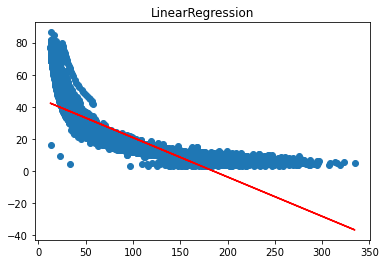

In [65]:
Y = df['distance'].values.reshape(-1, 1)
X = df['heigth_image'].values.reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.title('LinearRegression')

plt.show()

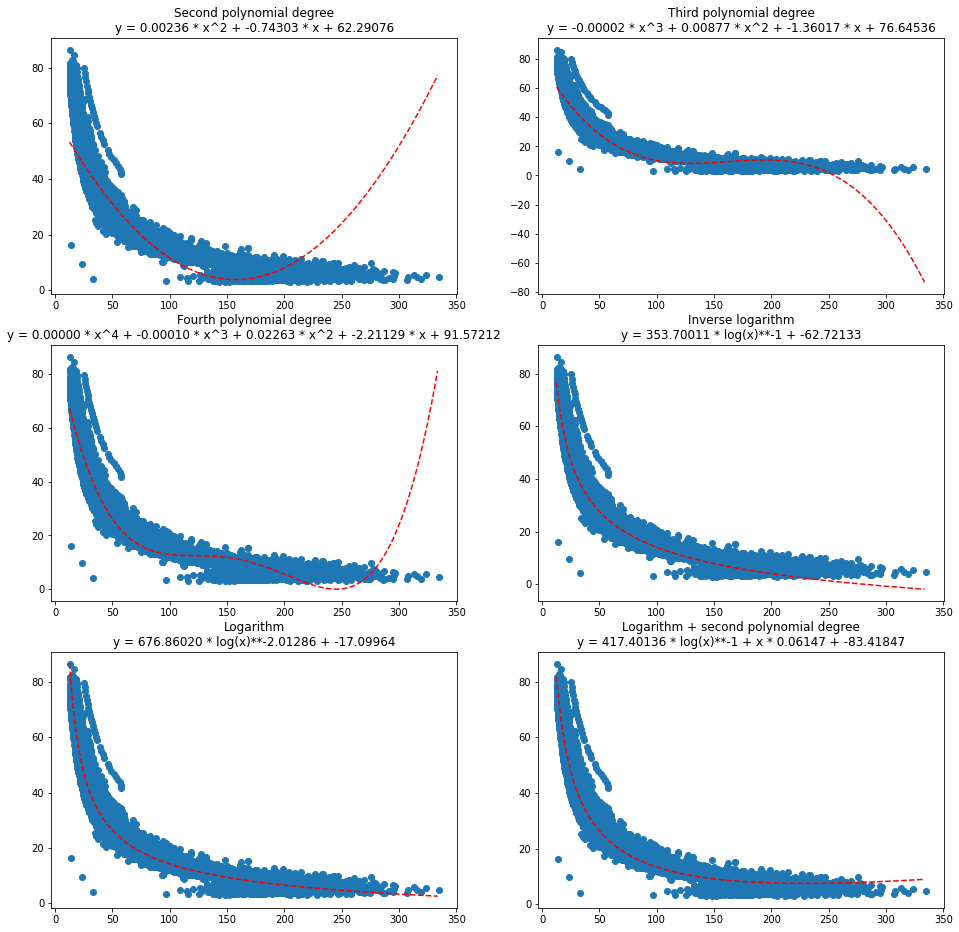

In [83]:
plt.figure(figsize=(16, 16))

Y = df['distance'].values
X = df['heigth_image'].values

def objective_2f(x, a, b, c):
    return a * x**2 + b * x + c

def objective_3f(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def objective_4f(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

def objective_log_1f(x, a, b):
    return a * np.log(x)**-1 + b 

def objective_log_f(x, a, b, c):
    return a * np.log(x)**b + c 

def objective_log_1_f(x, a, b, c):
    return a * np.log(x)**-1 + b * x + c 

plt.subplot(3, 2, 1)
popt, _ = curve_fit(objective_2f, X, Y, maxfev = 1000)
a, b, c = popt
plt.scatter(X, Y)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_2f(X_line, a, b, c)
plt.plot(X_line, Y_line, '--', color='red')
plt.title('Second polynomial degree\ny = %.5f * x^2 + %.5f * x + %.5f' % (a, b, c))

plt.subplot(3, 2, 2)
popt, _ = curve_fit(objective_3f, X, Y, maxfev = 1000)
a, b, c, d = popt
plt.scatter(X, Y)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_3f(X_line, a, b, c, d)
plt.plot(X_line, Y_line, '--', color='red')
plt.title('Third polynomial degree\ny = %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f' % (a, b, c, d))

plt.subplot(3, 2, 3)
popt, _ = curve_fit(objective_4f, X, Y, maxfev = 1000)
a, b, c, d, e = popt
plt.scatter(X, Y)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_4f(X_line, a, b, c, d, e)
plt.plot(X_line, Y_line, '--', color='red')
plt.title('Fourth polynomial degree\ny = %.5f * x^4 + %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f' % (a, b, c, d, e))

plt.subplot(3, 2, 4)
popt, _ = curve_fit(objective_log_1f, X, Y, maxfev = 1000)
a, b = popt
plt.scatter(X, Y)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_log_1f(X_line, a, b)
plt.plot(X_line, Y_line, '--', color='red')
plt.title('Inverse logarithm\ny = %.5f * log(x)**-1 + %.5f' % (a, b))

plt.subplot(3, 2, 5)
popt, _ = curve_fit(objective_log_f, X, Y, maxfev = 10000)
a, b, c = popt
plt.scatter(X, Y)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_log_f(X_line, a, b, c)
plt.plot(X_line, Y_line, '--', color='red')
plt.title('Logarithm\ny = %.5f * log(x)**%.5f + %.5f' % (a, b, c))

plt.subplot(3, 2, 6)
popt, _ = curve_fit(objective_log_1_f, X, Y, maxfev = 10000)
a, b, c = popt
plt.scatter(X, Y)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_log_1_f(X_line, a, b, c)
plt.plot(X_line, Y_line, '--', color='red')
plt.title('Logarithm + second polynomial degree\ny = %.5f * log(x)**-1 + x * %.5f + %.5f' % (a, b, c))

plt.show()

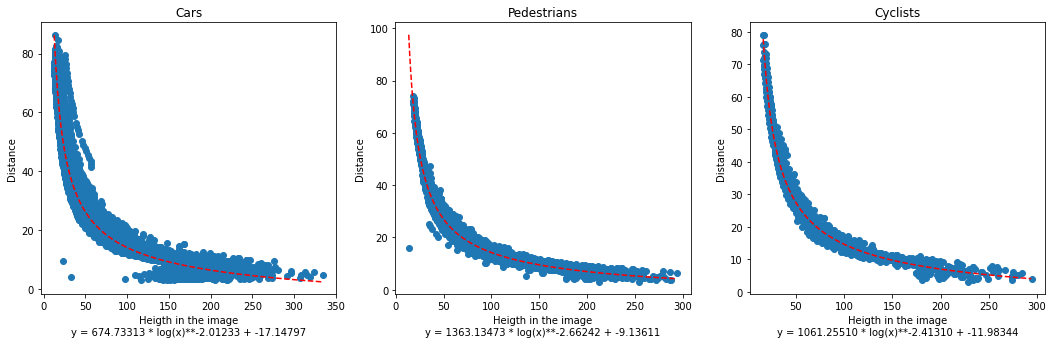

In [101]:
plt.figure(figsize=(18, 5))

df_car = df[df['type'] == 'Car']
df_pedestrian = df[df['type'] == 'Pedestrian']
df_cyclist = df[df['type'] == 'Cyclist']

def objective_log_f(x, a, b, c):
    return a * np.log(x)**b + c 

dfs = [df_car, df_pedestrian, df_cyclist]
titles = ['Cars', 'Pedestrians', 'Cyclists']

for i in range(3):
    plt.subplot(1, 3, i+1)
    X = dfs[i]['heigth_image']
    Y = dfs[i]['distance']
    popt, _ = curve_fit(objective_log_f, X, Y, maxfev = 1000000)
    a, b, c = popt
    plt.scatter(X, Y)
    X_line = np.arange(min(X), max(X), 1)
    Y_line = objective_log_f(X_line, a, b, c)
    plt.plot(X_line, Y_line, '--', color='red')
    plt.ylabel('Distance')
    plt.xlabel('Heigth in the image\ny = %.5f * log(x)**%.5f + %.5f' % (a, b, c))
    plt.title(titles[i])

plt.show()